In [1]:
from keras.api import layers, models
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
tf.random.set_seed(1)

from keras.api import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from keras.api.losses import CategoricalFocalCrossentropy, BinaryFocalCrossentropy
from keras.api.utils import to_categorical

# Sentiment classification

In [2]:
model = models.Sequential()

model.add(layers.Input(shape=(26, 300), name="Domain_1"))

model.add(layers.Flatten())

model.add(layers.Dense(200, activation='relu', name="layer_1"))

model.add(layers.Dropout(0.8, name="dropout_3"))

model.add(layers.BatchNormalization(name="batch_normalization_3"))

model.add(layers.Dense(100, activation='relu', name="layer_2"))

model.add(layers.Dropout(0.8, name="dropout_4"))

model.add(layers.BatchNormalization(name="batch_normalization_4"))

model.add(layers.Dense(3, activation='softmax', name="sentiment"))

model.compile(
    optimizer='adam',
    loss=[CategoricalFocalCrossentropy(alpha=[0.2, 0.3, 0.5])],
    metrics=['accuracy']
)

model.summary()

2025-02-15 22:26:25.558527: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-02-15 22:26:25.558557: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-02-15 22:26:25.558564: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
I0000 00:00:1739654785.558928 4041269 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1739654785.559210 4041269 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 7800)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_1 (Dense)                 │ (None, 200)            │     1,560,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_2 (Dense)                 │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sentiment (Dense)               │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,581,803 (6.03 MB)

 Trainable params: 1,581,203 (6.03 MB)

 Non-trainable params: 600 (2.34 KB)

In [3]:
df_original = pd.read_csv("data/processed/processed_tweets.csv")

In [4]:
df_with_unlabeled = df_original.copy()
df_with_unlabeled = df_with_unlabeled[df_with_unlabeled["Sentiment"].isna()]
df_original = df_original.dropna(subset=["Sentiment"])
df_original.info()

df_original["Sentiment"] = df_original["Sentiment"].map({-1: 0, 0: 1, 1: 2})

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 0 to 399
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   text           400 non-null    object 
 1   Sentiment      400 non-null    float64
 2   Has opinion    400 non-null    float64
 3   cleaned_text   400 non-null    object 
 4   word_vectors   400 non-null    object 
 5   glove_vectors  400 non-null    object 
dtypes: float64(2), object(4)
memory usage: 21.9+ KB


In [5]:
df_original["Sentiment"].value_counts()

Sentiment
0    243
1    133
2     24
Name: count, dtype: int64

In [6]:
padded_vectors = np.load("data/processed/padded_glove_vectors.npy")
padded_vectors = padded_vectors[:400]

one hot encoding

In [7]:
X_train, X_test, y_train, y_test = train_test_split(padded_vectors, df_original["Sentiment"], test_size=0.2, random_state=1, stratify=df_original["Sentiment"])
y_train_encoded = to_categorical(y_train, num_classes=3)
y_test_encoded = to_categorical(y_test, num_classes=3)

In [8]:
y_train_encoded

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0

In [9]:
unique_values, counts = np.unique(y_train, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

0: 195
1: 106
2: 19


In [10]:
unique_values, counts = np.unique(y_test, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

0: 48
1: 27
2: 5


In [11]:
history = model.fit(x=X_train, y=y_train_encoded, epochs=50)

Epoch 1/50


2025-02-15 22:26:34.772961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.3276 - loss: 0.3032
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3721 - loss: 0.2492
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4222 - loss: 0.2092
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4094 - loss: 0.2171
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4394 - loss: 0.2369
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4589 - loss: 0.2228
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4749 - loss: 0.1947
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4384 - loss: 0.1882
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4722 - loss: 0.1760
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4436 - loss: 0.1776
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4114 - loss: 0.1642
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4938 - l

In [12]:
model.save("models/experiment_2_sentiment_classification_model.keras")

Text(0.5, 0, 'epoch')

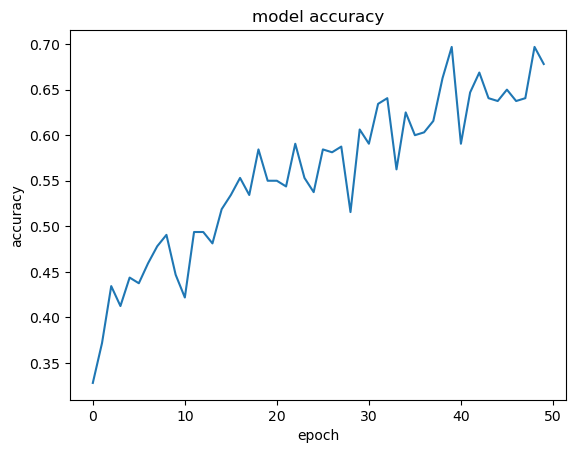

In [13]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

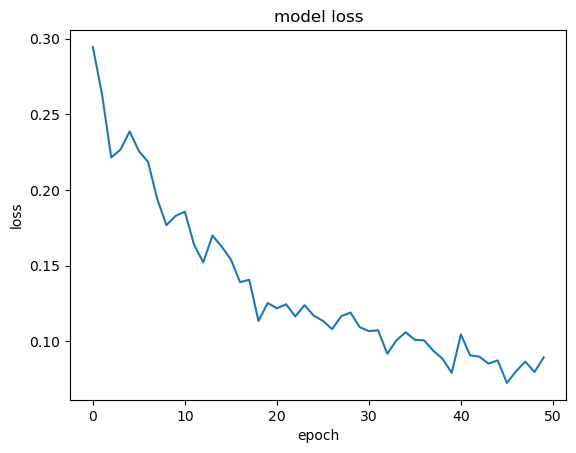

In [14]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

In [15]:
evaluation = model.evaluate(X_test, y_test_encoded, verbose=0)
print(f'Loss: {evaluation[0]}, accuracy: {evaluation[1]}')

Loss: 0.10241910070180893, accuracy: 0.6875


In [16]:
predictions = model.predict(X_test).argmax(axis=1)
print("Unique values in predictions:", np.unique(predictions))

print("Unique values in y_test:", np.unique(y_test))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Unique values in predictions: [0 1]
Unique values in y_test: [0 1 2]


[[41  7  0]
 [13 14  0]
 [ 5  0  0]]


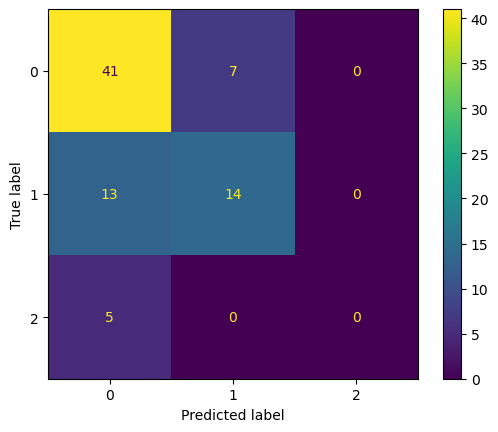

In [17]:
matrix = confusion_matrix(y_test, predictions)
print(matrix)
display = ConfusionMatrixDisplay(matrix)
display.plot()

# Opinion detection

In [18]:
model = models.Sequential()

model.add(layers.Input(shape=(26, 300), name="Domain_1"))

model.add(layers.Flatten())

model.add(layers.Dense(200, activation='relu', name="layer_1"))

model.add(layers.Dropout(0.8, name="dropout_3"))

model.add(layers.BatchNormalization(name="batch_normalization_3"))

model.add(layers.Dense(100, activation='relu', name="layer_2"))

model.add(layers.Dropout(0.8, name="dropout_4"))

model.add(layers.BatchNormalization(name="batch_normalization_4"))

model.add(layers.Dense(1, activation='sigmoid', name="opinion"))

model.compile(
    optimizer='adam',
    loss=[BinaryFocalCrossentropy(alpha=0.5)],
    metrics=['accuracy', metrics.Precision(name="precision"), metrics.Recall(name="recall")],
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 7800)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_1 (Dense)                 │ (None, 200)            │     1,560,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_2 (Dense)                 │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ opinion (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,581,601 (6.03 MB)

 Trainable params: 1,581,001 (6.03 MB)

 Non-trainable params: 600 (2.34 KB)

In [19]:
df_original = pd.read_csv("data/processed/processed_tweets.csv")

In [20]:
df_with_unlabeled = df_original.copy()
df_with_unlabeled = df_with_unlabeled[df_with_unlabeled["Has opinion"].isna()]
df_original = df_original.dropna(subset=["Has opinion"])
df_original.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 0 to 399
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   text           400 non-null    object 
 1   Sentiment      400 non-null    float64
 2   Has opinion    400 non-null    float64
 3   cleaned_text   400 non-null    object 
 4   word_vectors   400 non-null    object 
 5   glove_vectors  400 non-null    object 
dtypes: float64(2), object(4)
memory usage: 21.9+ KB


In [21]:
df_original["Has opinion"].value_counts()

Has opinion
0.0    209
1.0    191
Name: count, dtype: int64

In [22]:
padded_vectors = np.load("data/processed/padded_glove_vectors.npy")
padded_vectors = padded_vectors[:400]

In [23]:
X_train, X_test, y_train, y_test = train_test_split(padded_vectors, df_original["Has opinion"], test_size=0.2, random_state=1)
y_train_encoded = to_categorical(y_train, num_classes=2)
y_test_encoded = to_categorical(y_test, num_classes=2)

In [24]:
history = model.fit(x=X_train, y=y_train, epochs=50)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.4518 - loss: 0.4539 - precision: 0.4166 - recall: 0.4156
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5070 - loss: 0.3841 - precision: 0.4745 - recall: 0.4977
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5733 - loss: 0.3293 - precision: 0.5429 - recall: 0.5792
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5549 - loss: 0.3286 - precision: 0.5242 - recall: 0.4987
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6200 - loss: 0.2916 - precision: 0.5868 - recall: 0.6371
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5258 - loss: 0.3307 - precision: 0.4941 - recall: 0.5333
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5831 - loss: 0.2968 - precision: 0.5532 - recall: 0.5540
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6165 - loss: 0.2879 - precision: 0.5893 - recall: 0.5945
Epoch 9/50
10/10 ━━━━━━━

In [25]:
model.save("models/experiment_2_opinion_detection_model.keras")

Text(0.5, 0, 'epoch')

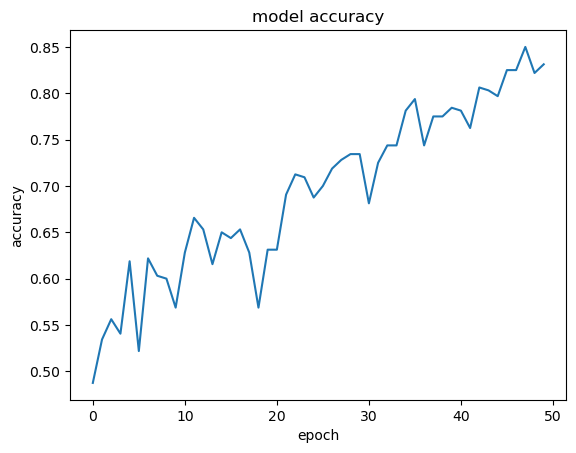

In [26]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

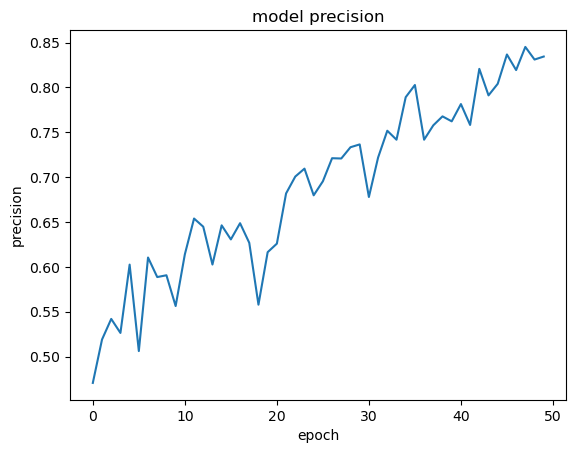

In [27]:
plt.plot(history.history['precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

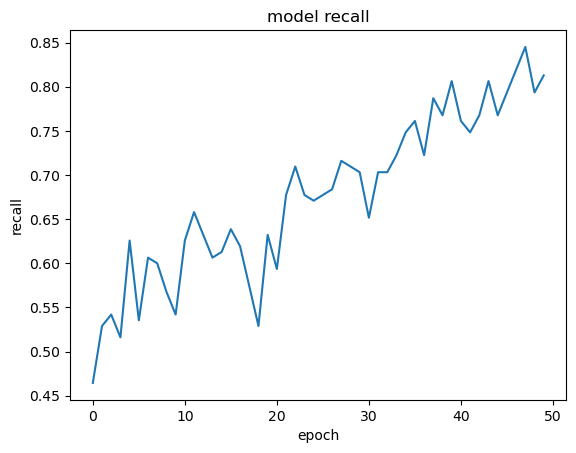

In [28]:
plt.plot(history.history['recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

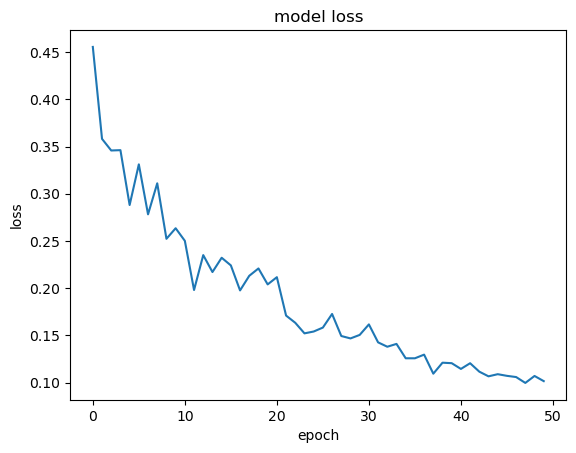

In [29]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

In [30]:
evaluation = model.evaluate(X_test, y_test)
print(f'Loss: {evaluation[0]}, accuracy: {evaluation[1]}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.6633 - loss: 0.1703 - precision: 0.5821 - recall: 0.6246
Loss: 0.1722363382577896, accuracy: 0.6625000238418579


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


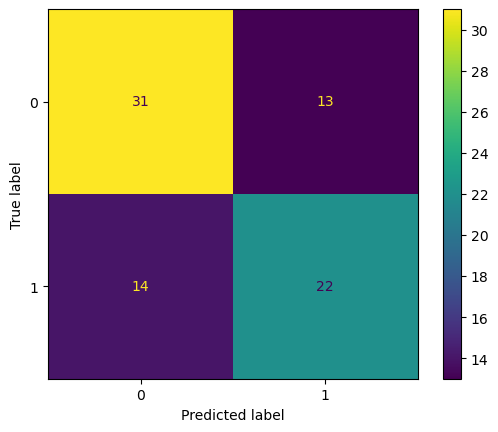

In [31]:
y_pred = (model.predict(X_test) > 0.5).astype(int)
matrix = confusion_matrix(y_test, y_pred)

display = ConfusionMatrixDisplay(matrix)
display.plot()